In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from classifier import MLPBinary
import utils

In [2]:
# resizing of the data created with monte carlo

lt, ut, t_step = 1.0, 3.2, 0.003

#for L in [10, 15, 20]:
 #   utils.resize_data(L, lt, ut)
    
utils.resize_data_test(10)

In [18]:
L=10
T_CRIT = 2.2691853 # k_b * T_C / J  with k_b=1, J = interaction constant
data = np.load(f"data/{L}mille.npy")#.reshape(-1, 100)
temps = np.load(f"data/{L}_temp_mille.npy")#.reshape(-1, 1)

# target value
t = ((temps > 2.5) | (temps < 2.0)).astype(int)

# removing data close to T_CRIT
idx = np.where(t==1)
data = data[idx]
temps = temps[idx]
n = data.shape[0]
t = (temps > T_CRIT).astype(int)

# DATA Shuffling
rng = np.random.default_rng()
indices = np.arange(data.shape[0])
rng.shuffle(indices)

data = data[indices]
t = t[indices]
temps = temps[indices]

# splitting data in 80% training, 20% validation, 10% test
a = int(0.9*n)
data_train = data[:a]
data_val = data[a:]

t_train = t[:a]
t_val = t[a:]

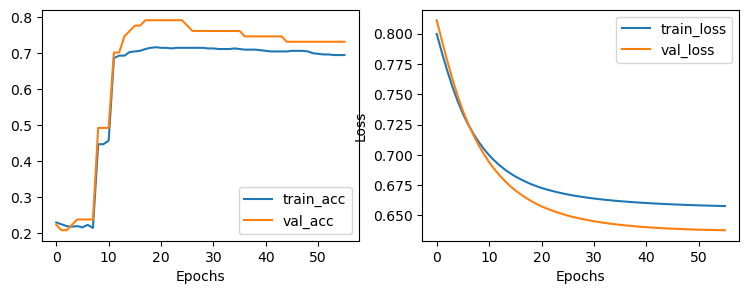

In [27]:
# CLASSIFIER TRAINING
clf = MLPBinary(dim_hidden=100, tolerance=1e-4, activation='relu', lr=0.001, batch_size=200, momentum=0.8, solver='sgd', alpha=0.8, power_t=0.1)
clf.fit(data_train, t_train, X_val=data_val, t_val=t_val)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
E = len(clf.train_acc) 
ax1.plot(np.arange(E), clf.train_acc)
ax1.plot(np.arange(E), clf.val_acc)
ax1.legend(["train_acc", "val_acc"])

ax2.plot(np.arange(E), clf.train_loss)
ax2.plot(np.arange(E), clf.val_loss)
ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])

In [32]:
b = clf.weights2.flatten()
b @ b.T

0.3303504819971447

In [26]:
clf.score(data_test[5], t_test[4])

0.4166666666666667

In [11]:
np.load(f"./data/10.npy").shape

(10, 1080, 100)

In [33]:
data_test.shape

(10, 24, 100)

In [34]:
# loading data for testing
temp_test = np.load(f"./data/{L}_test_temp.npy")
data_test = np.load(f"./data/{L}_test.npy")

# target value
tmp = temp_test.flatten()
temp_test = ((tmp > 2.5) | (tmp < 2.0)).astype(int)
temp_test.reshape(10,24)

# removing data close to T_CRIT
idx = np.where(temp_test==1)
data_test.reshape(240,100)
data_test = data_test[idx].reshape(10,24,100)
temp_test = temp_test[idx]
temp_test = (temps > T_CRIT).astype(int)

# sort data into ascending order according to temperatures
# potrei metterlo in utils

index = np.argsort(temp_test, axis=1)
temp_test = np.sort(temp_test, axis=1)
index_expanded = index[..., np.newaxis]
data_test = np.take_along_axis(data_test, index_expanded, axis=1)

t_test = (temp_test > T_CRIT).astype(int)

# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_probabilities(flattened).reshape(10, 24, 1)

plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), y[:,:,0].std(axis=0), fmt='s--g')


IndexError: index 10 is out of bounds for axis 0 with size 10

## SKLEARN

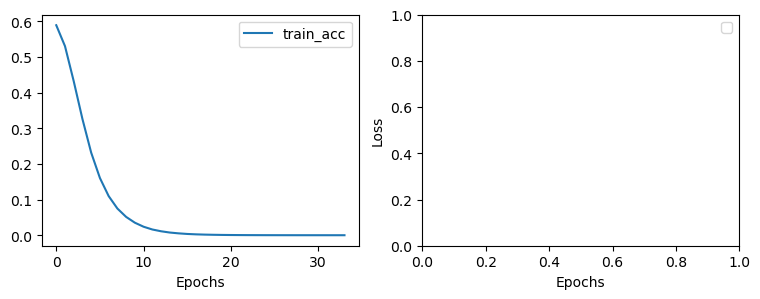

In [13]:
# using skleanr
clf = MLPClassifier(activation='relu', solver='sgd',alpha=0, momentum=1, nesterovs_momentum=False, power_t=1, verbose=False)
clf.fit(data_train, t_train)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))


E = len(clf.loss_curve_) 
ax1.plot(np.arange(E), clf.loss_curve_)

ax1.legend(["train_acc", "val_acc"])

ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])


In [18]:
a = clf.coefs_[1].flatten()
a @ a.T

120.98633692847629

In [7]:
min(clf.loss_curve_)

0.00013774753575584485

In [8]:
clf.score(data_test[4], t_test[0])

1.0

In [15]:
data_test.shape

(10, 24, 100)

In [16]:
# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_proba(flattened).reshape(10, 24, 2)

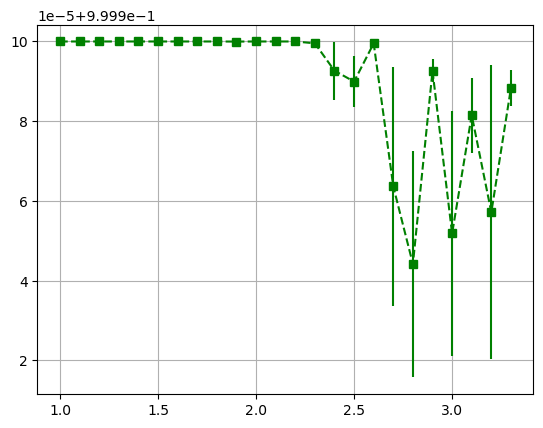

In [17]:
train_size = 10
errors = y[:,:,0].std(axis=0, ddof=1) / np.sqrt(train_size)  # std/(N-1)
plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), errors, fmt='s--g')
plt.grid(True)

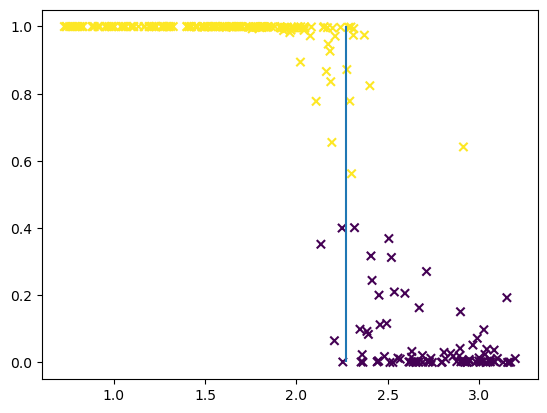

In [69]:
out = clf.predict_proba(data_val)
plt.scatter(temps[a:], out[:,1], marker='x', c=clf.predict(data_val) )
plt.vlines(T_CRIT, 0, 1)